In [1]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import sys

SOURCE_DIR = os.path.dirname(os.path.dirname(os.path.abspath(__name__)))
sys.path.insert(0, SOURCE_DIR)

In [3]:
# import logging
# import warnings

# logging.basicConfig(level=logging.DEBUG)
# warnings.filterwarnings('ignore')

In [4]:
# import tensorflow as tf

# tf.compat.v1.enable_eager_execution()

In [5]:
import malaya_speech
import malaya_speech.config
from malaya_speech.train.model import glowtts
import tensorflow as tf
import numpy as np
import math






The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [6]:
config = malaya_speech.config.fastspeech2_config
config['encoder_hidden_size'] = 192
config['encoder_num_hidden_layers'] = 6
config['encoder_attention_head_size'] = 32
config['encoder_intermediate_size'] = 768
config = glowtts.Config(vocab_size = 66, **config)
config_glowtts = glowtts.Config_GlowTTS(malaya_speech.config.glowtts_config)

In [7]:
i = tf.placeholder(tf.int32, [None, None])
i_lengths = tf.placeholder(tf.int32, [None])
mel_outputs = tf.placeholder(tf.float32, [None, None, 80])
mel_lengths = tf.placeholder(tf.int32, [None])

In [8]:
import pickle

with open('dataset-mel.pkl', 'rb') as fopen:
    data, d = pickle.load(fopen)
    
with open('dataset-mel-wav.pkl', 'rb') as fopen:
    wav = pickle.load(fopen)
    
data.keys()

dict_keys(['mel', 'text_ids', 'len_mel', 'len_text_ids', 'stop_token_target', 'f0', 'len_f0', 'energy', 'len_energy', 'g'])

In [9]:
# i = tf.convert_to_tensor(data['text_ids'])
# mel_outputs = tf.convert_to_tensor(data['mel'].astype(np.float32))
# mel_lengths = tf.convert_to_tensor(data['len_mel'][:,0])

In [10]:
model = glowtts.Model(config, config_glowtts)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor




In [11]:
o_ = model(i, gen = True, training = False, noise_scale=0.0)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [12]:
noise = tf.placeholder(tf.float32, shape=())
noise

<tf.Tensor 'Placeholder_4:0' shape=() dtype=float32>

In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [14]:
model.decoder.store_inverse()

In [15]:
(z, z_m, z_logs, logdet, z_mask), (x_m, x_logs, x_mask), (attn, logw, logw_) = model(i, 
                                                                                     gen = True, training = False,
                                                                                     noise_scale=noise)
(z, z_m, z_logs, logdet, z_mask), (x_m, x_logs, x_mask), (attn, logw, logw_)

((<tf.Tensor 'glowtts_1/FlowSpecDecoder/mul_4:0' shape=(?, ?, 80) dtype=float32>,
  <tf.Tensor 'glowtts_1/MatMul:0' shape=(?, ?, 80) dtype=float32>,
  <tf.Tensor 'glowtts_1/MatMul_1:0' shape=(?, ?, 80) dtype=float32>,
  None,
  <tf.Tensor 'glowtts_1/transpose_1:0' shape=(?, ?, 1) dtype=float32>),
 (<tf.Tensor 'glowtts_1/Encoder/mul:0' shape=(?, ?, 80) dtype=float32>,
  <tf.Tensor 'glowtts_1/Encoder/zeros_like:0' shape=(?, ?, 80) dtype=float32>,
  <tf.Tensor 'glowtts_1/Encoder/ExpandDims:0' shape=(?, ?, 1) dtype=float32>),
 (<tf.Tensor 'glowtts_1/ExpandDims_3:0' shape=(?, 1, ?, ?) dtype=float32>,
  <tf.Tensor 'glowtts_1/Encoder/ExpandDims_1:0' shape=(?, ?, 1) dtype=float32>,
  <tf.Tensor 'glowtts_1/mul_6:0' shape=(?, ?, 1) dtype=float32>))

In [16]:
len(tf.trainable_variables())

516

In [17]:
import collections
import re

def get_assignment_map_from_checkpoint(tvars, init_checkpoint, logging=True):
    """Compute the union of the current variables and checkpoint variables."""
    assignment_map = {}
    initialized_variable_names = {}

    name_to_variable = collections.OrderedDict()
    for var in tvars:
        name = var.name
        m = re.match('^(.*):\\d+$', name)
        if m is not None:
            name = m.group(1)
        name_to_variable[name] = var

    init_vars = tf.train.list_variables(init_checkpoint)

    assignment_map = collections.OrderedDict()
    for x in init_vars:
        (name, var) = (x[0], x[1])
        if name not in name_to_variable:
            continue

        assignment_map[name] = name
        assignment_map[name] = name_to_variable[name]
        initialized_variable_names[name] = 1
        initialized_variable_names[name + ':0'] = 1

    if logging:
        tf.logging.info('**** Trainable Variables ****')
        for var in tvars:
            init_string = ''
            if var.name in initialized_variable_names:
                init_string = ', *INIT_FROM_CKPT*'
            tf.logging.info(
                '  name = %s, shape = %s%s', var.name, var.shape, init_string
            )

    return (assignment_map, initialized_variable_names, name_to_variable)

In [18]:
assignment_map, _, name_to_variable = get_assignment_map_from_checkpoint(tf.trainable_variables(), 
                                                                         'test/model.ckpt')
len(assignment_map)

INFO:tensorflow:**** Trainable Variables ****


INFO:tensorflow:**** Trainable Variables ****


INFO:tensorflow:  name = n_blocks_1/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_1/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_1/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_1/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_1/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_1/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_2/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_2/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_2/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_2/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_2/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_2/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_3/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_3/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_3/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_3/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_3/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_3/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_4/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_4/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_4/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_4/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_4/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_4/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_5/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_5/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_5/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_5/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_5/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_5/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_6/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_6/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_6/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_6/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_6/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_6/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_7/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_7/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_7/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_7/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_7/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_7/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_8/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_8/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_8/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_8/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_8/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_8/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_9/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_9/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_9/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_9/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_9/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_9/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_10/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_10/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_10/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_10/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_10/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_10/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_11/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_11/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_11/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_11/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_11/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_11/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_12/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_12/logs:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_12/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_12/bias:0, shape = (1, 1, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_12/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = n_blocks_12/w_init:0, shape = (4, 4), *INIT_FROM_CKPT*


INFO:tensorflow:  name = weight:0, shape = (66, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = weight:0, shape = (66, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/embeddings/position_embeddings/embeddings:0, shape = (2049, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/embeddings/position_embeddings/embeddings:0, shape = (2049, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._0/kernel:0, shape = (5, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._0/kernel:0, shape = (5, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._0/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._0/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._1/kernel:0, shape = (5, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._1/kernel:0, shape = (5, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._1/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._1/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._2/kernel:0, shape = (5, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._2/kernel:0, shape = (5, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv_._2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/LayerNorm_._2/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/LayerNorm_._2/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/LayerNorm_._2/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/LayerNorm_._2/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv1d/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv1d/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv1d/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/ConvReluNorm_0/conv1d/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._0/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._1/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._2/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._3/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._4/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/query/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/query/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/key/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/key/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/value/kernel:0, shape = (192, 64), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/self/value/bias:0, shape = (64,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/output/dense/kernel:0, shape = (64, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/output/dense/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/attention/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/intermediate/conv1d_1/kernel:0, shape = (3, 192, 768), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/intermediate/conv1d_1/bias:0, shape = (768,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/intermediate/conv1d_2/kernel:0, shape = (3, 768, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/intermediate/conv1d_2/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/output/LayerNorm/gamma:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/encoder/layer_._5/output/LayerNorm/beta:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/conv1d_1/kernel:0, shape = (1, 192, 80), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/conv1d_1/kernel:0, shape = (1, 192, 80), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/conv1d_1/bias:0, shape = (80,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/conv1d_1/bias:0, shape = (80,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/conv_._0/kernel:0, shape = (3, 192, 256), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/conv_._0/kernel:0, shape = (3, 192, 256), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/conv_._0/bias:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/conv_._0/bias:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/LayerNorm_._0/gamma:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/LayerNorm_._0/gamma:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/LayerNorm_._0/beta:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/LayerNorm_._0/beta:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/conv_._1/kernel:0, shape = (3, 256, 256), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/conv_._1/kernel:0, shape = (3, 256, 256), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/conv_._1/bias:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/conv_._1/bias:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/LayerNorm_._1/gamma:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/LayerNorm_._1/gamma:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/LayerNorm_._1/beta:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/sequential/LayerNorm_._1/beta:0, shape = (256,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/dense/kernel:0, shape = (256, 1), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/dense/kernel:0, shape = (256, 1), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/dense/bias:0, shape = (1,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/Encoder/duration_predictor/dense/bias:0, shape = (1,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/weight_normalization_99/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/weight_normalization_99/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/weight_normalization_99/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/weight_normalization_99/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/weight_normalization_99/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/weight_normalization_99/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_100/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_100/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_100/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_100/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_100/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_100/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_101/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_101/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_101/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_101/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_101/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_101/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_102/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_102/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_102/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_102/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_102/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_102/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_103/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_103/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_103/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_103/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_103/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_103/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_104/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_104/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_104/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_104/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_104/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_104/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_105/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_105/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_105/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_105/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_105/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_105/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_106/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_106/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_106/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_106/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_106/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_106/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_107/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_107/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_107/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_107/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_107/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/WN_0/weight_normalization_107/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/conv1d_113/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/conv1d_113/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/conv1d_113/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_11/conv1d_113/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/weight_normalization_90/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/weight_normalization_90/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/weight_normalization_90/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/weight_normalization_90/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/weight_normalization_90/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/weight_normalization_90/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_91/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_91/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_91/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_91/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_91/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_91/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_92/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_92/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_92/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_92/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_92/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_92/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_93/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_93/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_93/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_93/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_93/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_93/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_94/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_94/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_94/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_94/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_94/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_94/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_95/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_95/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_95/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_95/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_95/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_95/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_96/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_96/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_96/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_96/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_96/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_96/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_97/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_97/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_97/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_97/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_97/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_97/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_98/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_98/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_98/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_98/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_98/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/WN_0/weight_normalization_98/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/conv1d_103/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/conv1d_103/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/conv1d_103/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_10/conv1d_103/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/weight_normalization_81/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/weight_normalization_81/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/weight_normalization_81/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/weight_normalization_81/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/weight_normalization_81/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/weight_normalization_81/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_82/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_82/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_82/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_82/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_82/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_82/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_83/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_83/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_83/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_83/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_83/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_83/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_84/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_84/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_84/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_84/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_84/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_84/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_85/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_85/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_85/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_85/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_85/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_85/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_86/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_86/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_86/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_86/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_86/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_86/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_87/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_87/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_87/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_87/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_87/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_87/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_88/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_88/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_88/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_88/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_88/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_88/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_89/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_89/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_89/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_89/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_89/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/WN_0/weight_normalization_89/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/conv1d_93/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/conv1d_93/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/conv1d_93/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_9/conv1d_93/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/weight_normalization_72/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/weight_normalization_72/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/weight_normalization_72/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/weight_normalization_72/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/weight_normalization_72/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/weight_normalization_72/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_73/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_73/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_73/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_73/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_73/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_73/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_74/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_74/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_74/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_74/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_74/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_74/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_75/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_75/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_75/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_75/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_75/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_75/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_76/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_76/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_76/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_76/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_76/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_76/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_77/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_77/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_77/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_77/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_77/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_77/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_78/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_78/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_78/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_78/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_78/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_78/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_79/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_79/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_79/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_79/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_79/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_79/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_80/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_80/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_80/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_80/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_80/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/WN_0/weight_normalization_80/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/conv1d_83/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/conv1d_83/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/conv1d_83/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_8/conv1d_83/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/weight_normalization_63/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/weight_normalization_63/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/weight_normalization_63/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/weight_normalization_63/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/weight_normalization_63/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/weight_normalization_63/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_64/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_64/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_64/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_64/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_64/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_64/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_65/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_65/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_65/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_65/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_65/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_65/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_66/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_66/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_66/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_66/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_66/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_66/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_67/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_67/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_67/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_67/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_67/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_67/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_68/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_68/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_68/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_68/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_68/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_68/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_69/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_69/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_69/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_69/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_69/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_69/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_70/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_70/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_70/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_70/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_70/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_70/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_71/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_71/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_71/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_71/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_71/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/WN_0/weight_normalization_71/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/conv1d_73/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/conv1d_73/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/conv1d_73/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_7/conv1d_73/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/weight_normalization_54/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/weight_normalization_54/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/weight_normalization_54/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/weight_normalization_54/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/weight_normalization_54/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/weight_normalization_54/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_55/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_55/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_55/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_55/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_55/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_55/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_56/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_56/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_56/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_56/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_56/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_56/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_57/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_57/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_57/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_57/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_57/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_57/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_58/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_58/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_58/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_58/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_58/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_58/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_59/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_59/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_59/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_59/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_59/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_59/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_60/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_60/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_60/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_60/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_60/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_60/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_61/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_61/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_61/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_61/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_61/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_61/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_62/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_62/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_62/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_62/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_62/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/WN_0/weight_normalization_62/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/conv1d_63/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/conv1d_63/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/conv1d_63/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_6/conv1d_63/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/weight_normalization_45/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/weight_normalization_45/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/weight_normalization_45/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/weight_normalization_45/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/weight_normalization_45/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/weight_normalization_45/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_46/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_46/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_46/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_46/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_46/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_46/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_47/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_47/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_47/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_47/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_47/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_47/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_48/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_48/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_48/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_48/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_48/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_48/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_49/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_49/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_49/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_49/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_49/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_49/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_50/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_50/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_50/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_50/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_50/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_50/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_51/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_51/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_51/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_51/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_51/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_51/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_52/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_52/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_52/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_52/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_52/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_52/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_53/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_53/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_53/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_53/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_53/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/WN_0/weight_normalization_53/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/conv1d_53/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/conv1d_53/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/conv1d_53/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_5/conv1d_53/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/weight_normalization_36/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/weight_normalization_36/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/weight_normalization_36/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/weight_normalization_36/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/weight_normalization_36/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/weight_normalization_36/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_37/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_37/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_37/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_37/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_37/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_37/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_38/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_38/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_38/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_38/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_38/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_38/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_39/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_39/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_39/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_39/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_39/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_39/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_40/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_40/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_40/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_40/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_40/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_40/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_41/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_41/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_41/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_41/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_41/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_41/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_42/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_42/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_42/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_42/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_42/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_42/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_43/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_43/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_43/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_43/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_43/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_43/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_44/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_44/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_44/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_44/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_44/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/WN_0/weight_normalization_44/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/conv1d_43/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/conv1d_43/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/conv1d_43/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_4/conv1d_43/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/weight_normalization_27/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/weight_normalization_27/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/weight_normalization_27/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/weight_normalization_27/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/weight_normalization_27/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/weight_normalization_27/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_28/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_28/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_28/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_28/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_28/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_28/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_29/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_29/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_29/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_29/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_29/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_29/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_30/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_30/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_30/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_30/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_30/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_30/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_31/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_31/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_31/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_31/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_31/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_31/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_32/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_32/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_32/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_32/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_32/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_32/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_33/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_33/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_33/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_33/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_33/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_33/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_34/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_34/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_34/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_34/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_34/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_34/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_35/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_35/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_35/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_35/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_35/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/WN_0/weight_normalization_35/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/conv1d_33/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/conv1d_33/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/conv1d_33/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_3/conv1d_33/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/weight_normalization_18/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/weight_normalization_18/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/weight_normalization_18/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/weight_normalization_18/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/weight_normalization_18/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/weight_normalization_18/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_19/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_19/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_19/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_19/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_19/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_19/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_20/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_20/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_20/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_20/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_20/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_20/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_21/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_21/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_21/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_21/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_21/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_21/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_22/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_22/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_22/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_22/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_22/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_22/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_23/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_23/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_23/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_23/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_23/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_23/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_24/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_24/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_24/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_24/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_24/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_24/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_25/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_25/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_25/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_25/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_25/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_25/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_26/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_26/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_26/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_26/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_26/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/WN_0/weight_normalization_26/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/conv1d_23/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/conv1d_23/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/conv1d_23/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_2/conv1d_23/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/weight_normalization_9/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/weight_normalization_9/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/weight_normalization_9/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/weight_normalization_9/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/weight_normalization_9/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/weight_normalization_9/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_10/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_10/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_10/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_10/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_10/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_10/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_11/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_11/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_11/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_11/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_11/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_11/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_12/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_12/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_12/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_12/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_12/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_12/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_13/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_13/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_13/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_13/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_13/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_13/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_14/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_14/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_14/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_14/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_14/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_14/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_15/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_15/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_15/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_15/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_15/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_15/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_16/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_16/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_16/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_16/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_16/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_16/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_17/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_17/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_17/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_17/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_17/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/WN_0/weight_normalization_17/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/conv1d_13/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/conv1d_13/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/conv1d_13/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_1/conv1d_13/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/weight_normalization/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/weight_normalization/kernel:0, shape = (1, 80, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/weight_normalization/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/weight_normalization/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/weight_normalization/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/weight_normalization/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_1/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_1/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_1/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_1/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_1/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_1/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_2/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_2/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_2/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_2/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_2/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_2/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_3/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_3/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_3/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_3/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_3/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_3/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_4/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_4/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_4/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_4/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_4/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_4/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_5/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_5/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_5/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_5/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_5/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_5/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_6/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_6/kernel:0, shape = (1, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_6/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_6/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_6/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_6/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_7/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_7/kernel:0, shape = (3, 192, 384), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_7/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_7/bias:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_7/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_7/g:0, shape = (384,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_8/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_8/kernel:0, shape = (1, 192, 192), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_8/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_8/bias:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_8/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/WN_0/weight_normalization_8/g:0, shape = (192,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/conv1d_3/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/conv1d_3/kernel:0, shape = (1, 192, 160), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/conv1d_3/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = glowtts/FlowSpecDecoder/CouplingBlock_0/conv1d_3/bias:0, shape = (160,), *INIT_FROM_CKPT*


INFO:tensorflow:  name = kernel:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_1:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_1:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_2:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_2:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_3:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_3:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_4:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_4:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_5:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_5:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_6:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_6:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_7:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_7:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_8:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_8:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_9:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_9:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_10:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_10:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_11:0, shape = (1, 80, 192)


INFO:tensorflow:  name = kernel_11:0, shape = (1, 80, 192)


504

In [19]:
init_vars = tf.train.list_variables('test/model.ckpt')
kernels = []
for v in init_vars:
    if v[1] == [1, 80, 192]:
        kernels.append(v[0])
        
kernels = sorted(kernels, key=lambda k: int(k.split('glowtts/FlowSpecDecoder/CouplingBlock_')[1].split('/')[0]))

In [20]:
for no, k in enumerate(kernels):
    base = 'kernel'
    if no > 0:
        base = f'{base}_{no}'
    assignment_map[k] = name_to_variable[base]

In [21]:
saver = tf.train.Saver(assignment_map)
saver.restore(sess, 'test/model.ckpt')

INFO:tensorflow:Restoring parameters from test/model.ckpt


INFO:tensorflow:Restoring parameters from test/model.ckpt


In [35]:
o_ = sess.run(z, feed_dict = {i: data['text_ids'], noise: 1.0})
o_.shape

(1, 370, 80)

In [36]:
import matplotlib.pyplot as plt

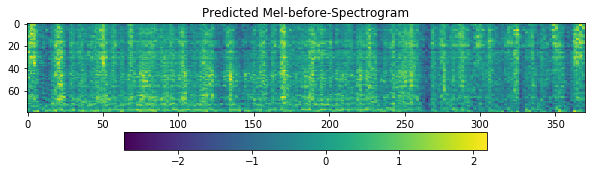

In [37]:
mel_outputs_ = np.reshape(o_, [-1, 80])
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(311)
ax1.set_title(f'Predicted Mel-before-Spectrogram')
im = ax1.imshow(np.rot90(mel_outputs_), aspect='auto', interpolation='none')
fig.colorbar(mappable=im, shrink=0.65, orientation='horizontal', ax=ax1)
plt.show()

In [ ]:
o_ = sess.run(z_mask, feed_dict = {i: data['text_ids']})
o_.shape

In [ ]:
o_ = sess.run(logw, feed_dict = {i: data['text_ids']})
o_.shape

In [ ]:
o_ = sess.run(z_logs, feed_dict = {i: data['text_ids']})
o_.shape

In [ ]:
o_[0]

In [ ]:
!ls -lh test
!rm -rf test